In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
train = np.loadtxt('train.txt', delimiter =',')
dev = np.loadtxt('dev.txt', delimiter =',')
realtrain = np.loadtxt('realtrain.txt', delimiter =',')
realdev = np.loadtxt('realdev.txt', delimiter =',')
nontrain = np.loadtxt('nontrain.txt', delimiter =',')
nondev = np.loadtxt('nondev.txt', delimiter =',')

In [4]:
def trainclass(x):
    c1 = x[:350, :]; c2 = x[350:700, :]; c3 = x[700:1050, :]
    return (c1, c2, c3)

In [5]:
def devclass(x):
    c1 = x[:100, :]; c2 = x[100:200, :]; c3 = x[200:300, :]
    return (c1, c2, c3)

In [6]:
def stats(x):
    μ = np.array([np.mean(x[:,0]), np.mean(x[:,1])])
    μ = np.reshape(μ, (len(μ),1)).T
    Σ = np.cov(x, rowvar=False)
    return (μ, Σ)

In [7]:
def gaussian(x, μ, Σ):
    d = len(μ[0])
    exponent = np.exp(-0.5*(x-μ)@np.linalg.inv(Σ)@(x-μ).T )
    det = 1/(np.linalg.det(Σ))**0.5
    gdf = 1/(2*np.pi)**(d/2)*det*exponent
    return float(gdf[0])

In [169]:
# def bayesian1(x, xtest):
# #     eye = np.identity(2)
#     (c1, c2, c3) = trainclass(x)
#     (m1, s1) = stats(c1[:, :2]); (m2, s2) = stats(c2[:, :2]); (m3, s3) = stats(c3[:, :2])
#     #c = np.cov(x[:, :2], rowvar=False)
#     #c = (np.sum(np.cov(x[:, :2], rowvar=False)*eye)*0.5)*eye
#     #c = np.cov(x[:, :2], rowvar=False)*eye
#     #s1=c;s2=c;s3=c
# #     s1 = s1*eye; s2=s2*eye; s3=s3*eye
#     ytest = np.empty([0],dtype=float)
#     for i in range(len(xtest)):
#         gdf1 = gaussian(xtest[i,:], m1, s1)#here
#         gdf2 = gaussian(xtest[i,:], m2, s2)#here
#         gdf3 = gaussian(xtest[i,:], m3, s3)#here
#         ytest = np.append(ytest,np.argmax([gdf1,gdf2,gdf3])+1)
#     return ytest

In [ ]:
def bayesian(x, xtest, case):
    (c1, c2, c3) = trainclass(x)
    (m1, s1) = stats(c1[:, :2]); (m2, s2) = stats(c2[:, :2]); (m3, s3) = stats(c3[:, :2])
    m = np.concatenate([m1, m2, m3], axis=0)
    eye = np.identity(2)
    P = np.zeros([len(xtest), 3])
    for i in range(len(xtest)):
        for j in range(3):
                if case == 'case1':
                    cov = np.cov(x[:, :2], rowvar=False)
                elif case == 'case2':
                    cov = np.stack((s1,s2,s3))[j]
                elif case == 'case3':
                    cov = (np.sum(np.cov(x[:, :2], rowvar=False)*eye)*0.5)*eye
                elif case == 'case4':
                    cov = np.cov(x[:, :2], rowvar=False)*eye
                elif case == 'case5':
                    cov = np.stack((s1,s2,s3))[j]*eye
                P[i, j] = 1/3*gaussian(xtest[i, :], np.array([m[j, :]]), cov)
    ytest = []
    for i in range(len(xtest)):
        ytest.append(np.argmax(P[i,:])+1)
    return ytest

In [213]:
def ROC(x, xtest, ytest, case, f):
    (c1, c2, c3) = trainclass(x)
    (m1, s1) = stats(c1[:, :2]); (m2, s2) = stats(c2[:, :2]); (m3, s3) = stats(c3[:, :2])
    m = np.concatenate([m1, m2, m3], axis=0)
#     threshold_min = 0
#     threshold_max = 0
    eye = np.identity(2)
    P = np.zeros([len(xtest), 3])
    for i in range(len(xtest)):
        for j in range(3):
                if case == 'case1':
                    cov = np.cov(x[:, :2], rowvar=False)
                elif case == 'case2':
                    cov = np.stack((s1,s2,s3))[j]
                elif case == 'case3':
                    cov = (np.sum(np.cov(x[:, :2], rowvar=False)*eye)*0.5)*eye
                elif case == 'case4':
                    cov = np.cov(x[:, :2], rowvar=False)*eye
                elif case == 'case5':
                    cov = np.stack((s1,s2,s3))[j]*eye
                P[i, j] = 1/3*gaussian(xtest[i, :], np.array([m[j, :]]), cov)
                
    threshold_min = np.min(P)
    threshold_max = np.max(P)
    
#     for k in range(-200,0):    
#         threshold_vec[k] = np.exp(k)
    threshold_vec = np.linspace(threshold_min, threshold_max, f)
    
    TPR = []; FPR = []
    for threshold in threshold_vec:
        TP, FP = 0, 0
        TN, FN = 0, 0
        for i in range(len(xtest)):
            for j in range(3):
                if P[i, j]>=threshold:
                    if ytest[i] == j+1:
                        TP += 1
                    else:
                        FP += 1
                else:
                    if ytest[i] == j+1:
                        FN += 1
                    else:
                        TN += 1
        TPR.append(TP/(TP+FN))
        FPR.append(FP/(FP+TN))
    return (TPR, FPR)

In [235]:
C = train
p = 1
# (c1, c2, c3) = trainclass(C) #  
# (m1, s1) = stats(c1[:, :2]); (m2, s2) = stats(c2[:, :2]); (m3, s3) = stats(c3[:, :2])

min1, max1 = C[:, 0].min()-1, C[:, 0].max()+1 #
min2, max2 = C[:, 1].min()-1, C[:, 1].max()+1 #
x1grid = np.arange(min1, max1, p)
x2grid = np.arange(min2, max2, p)
xx, yy = np.meshgrid(x1grid, x2grid)
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
grid = np.hstack((r1,r2))

case = 'case5'
y = bayesian(C, grid, case)
# (TPR, FPR) = ROC(C, grid, y, case, 2000)
# plt.plot(FPR, TPR,'r')
# (TPR, FPR) = ROC(C, grid, y, case, 50)
# plt.plot(FPR, TPR,)
# z = np.reshape(y,(((np.shape(x2grid))[0]),((np.shape(x1grid))[0])))
# plt.title('Naive Bayes with C different for all classes')

# plt.contourf(xx, yy, z, levels=2)
# cl1 = plt.scatter(c1[:, 0], c1[:, 1],marker="*")
# cl2 = plt.scatter(c2[:, 0], c2[:, 1],marker="x")
# cl3 = plt.scatter(c3[:, 0], c3[:, 1],marker=".")
# plt.legend((cl1,cl2,cl3),('Class-1' , 'Class-2', 'Class-3'), loc= 'upper right')
# plt.show()

In [237]:
x1grid.shape

(27,)

In [212]:
# for j in range(3):
#     print(np.stack((s1,s2,s3))[j]-s1)
np.exp(-100)

3.720075976020836e-44

Text(0.5, 1.0, 'Naive Bayes with C different for all classes')

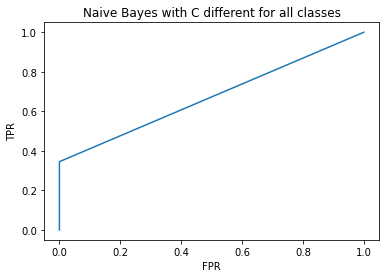

In [137]:
# case = input()
# print('Enter the case for which ROC is to be plotted: ', case)
case = 'case2'
(TPR, FPR) = ROC(C, grid, y, case)
plt.plot(FPR, TPR)
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('Naive Bayes with C different for all classes')
#'Bayes with Covariance same for all classes'
#'Bayes with Covariance different for all classes'
#'Naive Bayes with C = sigma^2*I'
#'Naive Bayes with C same for all classes'
#'Naive Bayes with C different for all classes'

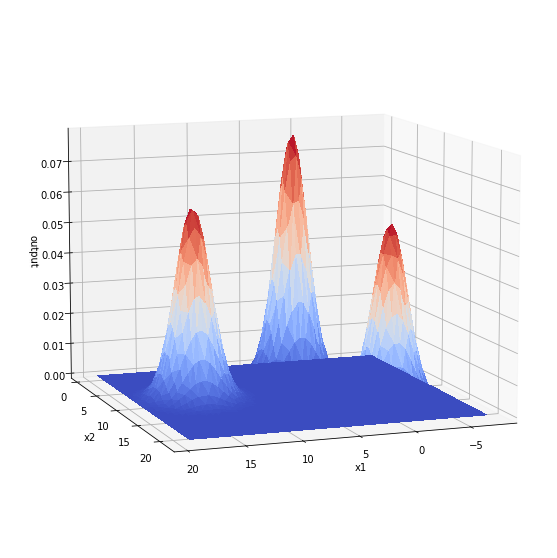

In [178]:
gdf1 = []; gdf2 = []; gdf3 = []
for i in range(len(grid)):
    g1 = gaussian(grid[i,:], m1, s1); gdf1.append(g1)
    g2 = gaussian(grid[i,:], m2, s2); gdf2.append(g2)
    g3 = gaussian(grid[i,:], m3, s3); gdf3.append(g3)


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

#Creating plot
ax.plot_trisurf(grid[:,0],grid[:,1],gdf3,cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.plot_trisurf(grid[:,0],grid[:,1],gdf2,cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.plot_trisurf(grid[:,0],grid[:,1],gdf1,cmap=cm.coolwarm,linewidth=0, antialiased=False)

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('output')
ax.view_init(10, 70)
# show plot
plt.show()

In [186]:
y_pred = bayesian(nontrain,nondev[:,:2])
y_test = nondev[:,2]

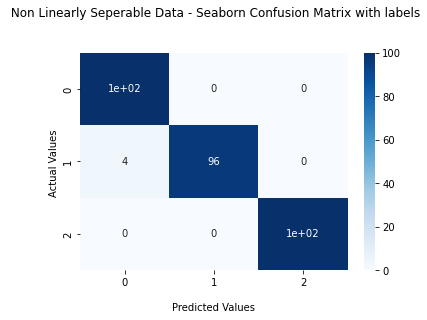

In [188]:
cf_matrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title(' Non Linearly Seperable Data - Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
# ax.xaxis.set_ticklabels(['False','True'])
# ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()